In [1]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

ImportError: cannot import name 'to_categorical' from 'keras.utils' (C:\Users\abdur\anaconda3\envs\tf-env\lib\site-packages\keras\utils\__init__.py)

In [ ]:
TRAIN_DIR = 'C:/College/Semester 5/Computer Vision/Project/Mini Project/archive/train'
TEST_DIR = 'C:/College/Semester 5/Computer Vision/Project/Mini Project/archive/test'

In [ ]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

In [ ]:
from tqdm import tqdm



In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale' )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features
    

In [ ]:
train_features = extract_features(train['image'])

In [ ]:
test_features = extract_features(test['image'])

In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

In [ ]:
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
le.fit(train['label'])

In [ ]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

In [ ]:
def get_model():
   gpu_model = Sequential()
# convolutional layers
   gpu_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
   gpu_model.add(MaxPooling2D(pool_size=(2,2)))
   gpu_model.add(Dropout(0.3))

   gpu_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
   gpu_model.add(MaxPooling2D(pool_size=(2,2)))
   gpu_model.add(Dropout(0.3))

   gpu_model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
   gpu_model.add(MaxPooling2D(pool_size=(2,2)))
   gpu_model.add(Dropout(0.3))

   gpu_model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
   gpu_model.add(MaxPooling2D(pool_size=(2,2)))
   gpu_model.add(Dropout(0.3))

   gpu_model.add(Flatten())
# fully connected layers
   gpu_model.add(Dense(512, activation='relu'))
   gpu_model.add(Dropout(0.3))
   gpu_model.add(Dense(256, activation='relu'))
   gpu_model.add(Dropout(0.3))
# output layer
   gpu_model.add(Dense(7, activation='softmax'))
    


    return gpu_model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Apply transformations and batch the data efficiently
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)


# Initialize the MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Train thegpu_model with the efficient data pipeline
with strategy.scope():
    gpu_model = get_model()
    gpu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gpu_model.fit(train_dataset, epochs=100, callbacks=[lr_reduction])

model_json = gpu_model.to_json()
with open("emotiondetector_final(h5).json",'w') as json_file:
    json_file.write(model_json)
gpu_model.save("emotiondetectorfinal(h5).h5")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Define the model architecture
def get_model():
    gpu_model = Sequential()

    # Convolutional layers with BatchNormalization
    gpu_model.add(Conv2D(128, kernel_size=(3,3), activation=None, input_shape=(48,48,1)))
    gpu_model.add(BatchNormalization())
    gpu_model.add(Activation('relu'))
    gpu_model.add(MaxPooling2D(pool_size=(2,2)))
    gpu_model.add(Dropout(0.3))

    gpu_model.add(Conv2D(256, kernel_size=(3,3), activation=None))
    gpu_model.add(BatchNormalization())
    gpu_model.add(Activation('relu'))
    gpu_model.add(MaxPooling2D(pool_size=(2,2)))
    gpu_model.add(Dropout(0.3))

    gpu_model.add(Conv2D(512, kernel_size=(3,3), activation=None))
    gpu_model.add(BatchNormalization())
    gpu_model.add(Activation('relu'))
    gpu_model.add(MaxPooling2D(pool_size=(2,2)))
    gpu_model.add(Dropout(0.3))

    gpu_model.add(Conv2D(512, kernel_size=(3,3), activation=None))
    gpu_model.add(BatchNormalization())
    gpu_model.add(Activation('relu'))
    gpu_model.add(MaxPooling2D(pool_size=(2,2)))
    gpu_model.add(Dropout(0.3))

    gpu_model.add(Flatten())

    # Fully connected layers
    gpu_model.add(Dense(512, activation='relu'))
    gpu_model.add(Dropout(0.3))
    gpu_model.add(Dense(256, activation='relu'))
    gpu_model.add(Dropout(0.3))

    # Output layer
    gpu_model.add(Dense(7, activation='softmax'))

    return gpu_model

# Data augmentation with simpler settings
datagen = ImageDataGenerator(
    horizontal_flip=True,  
    zoom_range=0.1
)

datagen.fit(x_train)

# Reduce learning rate based on validation accuracy
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# Initialize the MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Train the model with the efficient data pipeline
with strategy.scope():
    gpu_model = get_model()
    gpu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gpu_model.fit(train_dataset, 
              epochs=100,  # 20% of the training data will be used for validation
              callbacks=[lr_reduction], 
              shuffle=True)

# Save the model and architecture
model_json = gpu_model.to_json()
with open("emotiondetector_final.json",'w') as json_file:
    json_file.write(model_json)
gpu_model.save("emotiondetector_final.h5")


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load model architecture and weights
with open('/kaggle/input/emotion_detector_final/tensorflow2/default/1/emotiondetector_final.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('/kaggle/input/emotion_detector_final/tensorflow2/default/1/emotiondetector_final.h5')
print("Model loaded successfully!")

# Class labels (order should match the training data)
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array.reshape(1, 48, 48, 1)

# Paths to test data
test_dir = '/kaggle/input/fer2013/test'  # Update this path if necessary

# Initialize lists to hold true labels and predictions
true_labels = []
predicted_labels = []

# Iterate through each folder (emotion category) in the test directory
for emotion in os.listdir(test_dir):
    emotion_dir = os.path.join(test_dir, emotion)
    if not os.path.isdir(emotion_dir):
        continue
    for img_file in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_file)
        if img_path.endswith(('png', 'jpg', 'jpeg')):  # Check for valid image formats
            # Preprocess the image and get prediction
            img = preprocess_image(img_path)
            prediction = np.argmax(model.predict(img))
            predicted_labels.append(prediction)

            # Append true label (based on folder name)
            true_labels.append(class_labels.index(emotion))

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━

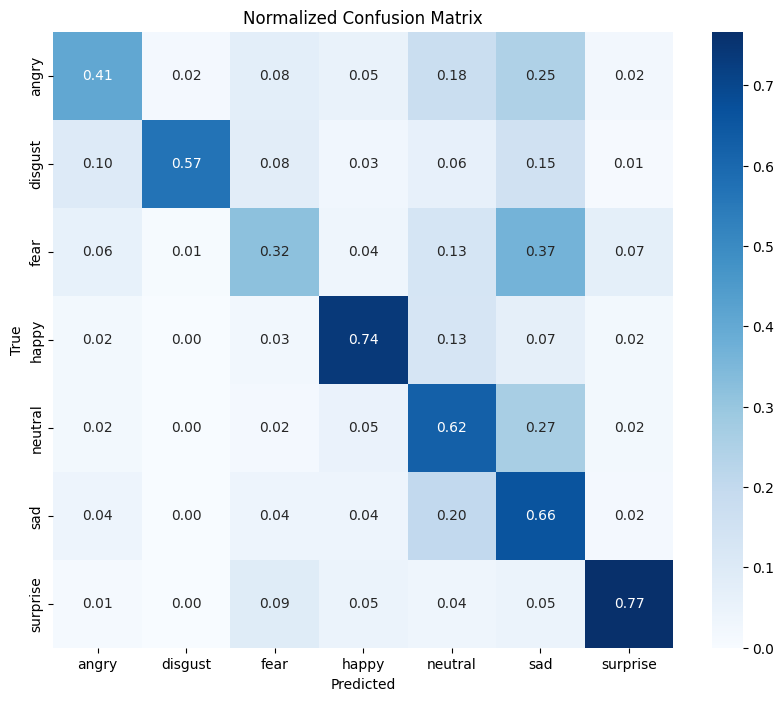

In [14]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


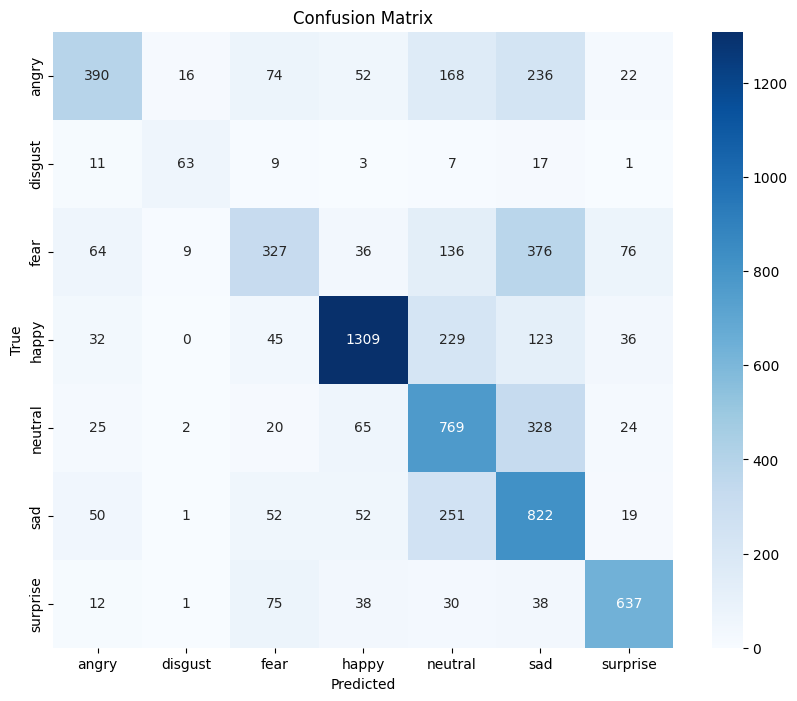

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


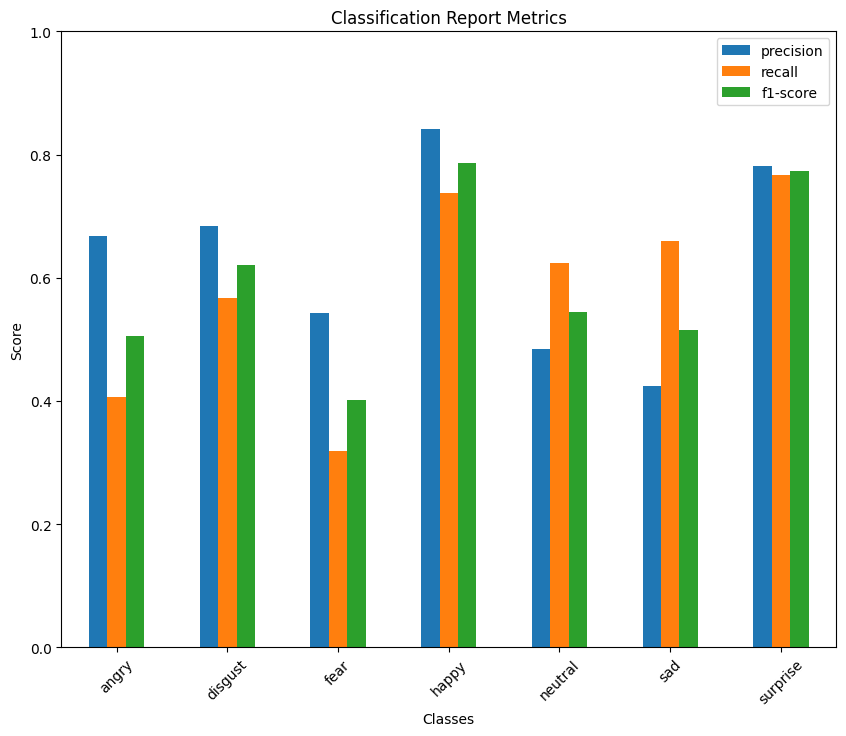

In [16]:
#2. Classification Report Visualization
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score
report_df = report_df[:-3]  # Exclude averages
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 8))
plt.title("Classification Report Metrics")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


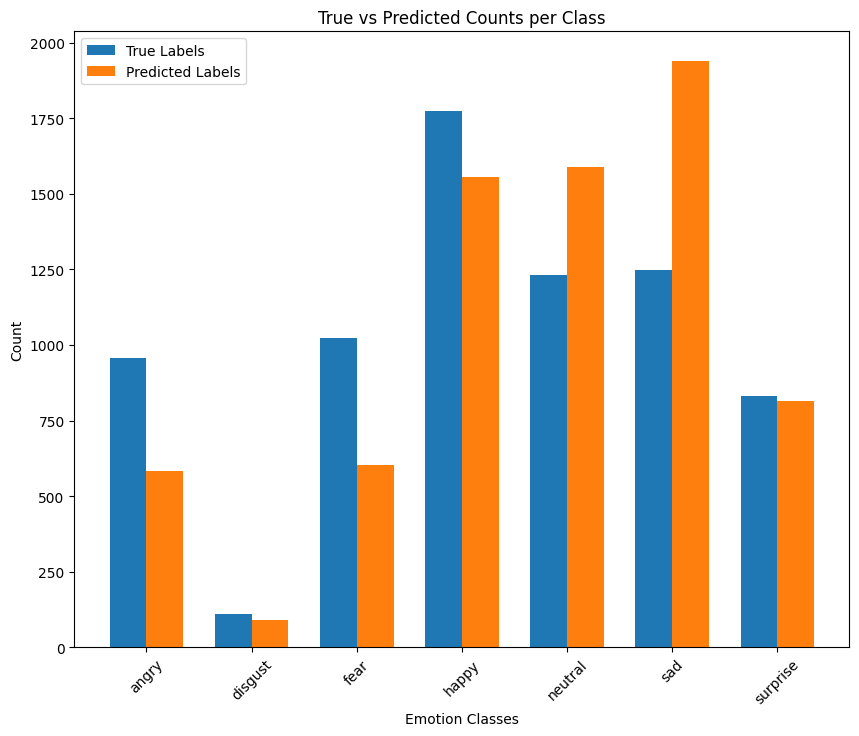

In [17]:
#3. Emotion-wise Prediction Distribution
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of true and predicted labels
true_counts = np.bincount(true_labels, minlength=len(class_labels))
predicted_counts = np.bincount(predicted_labels, minlength=len(class_labels))

# Plot true vs predicted counts
x = np.arange(len(class_labels))
width = 0.35  # Bar width

plt.figure(figsize=(10, 8))
plt.bar(x - width/2, true_counts, width, label='True Labels')
plt.bar(x + width/2, predicted_counts, width, label='Predicted Labels')
plt.title("True vs Predicted Counts per Class")
plt.xlabel("Emotion Classes")
plt.ylabel("Count")
plt.xticks(ticks=x, labels=class_labels, rotation=45)
plt.legend()
plt.show()
